# Lav kortplots med geopandas

## Import pakker

In [1]:
import geopandas, pandas as pd, numpy as np
import requests, json, csv, re
import matplotlib
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns

#import PyDST

## Hent data med dst-API

In [2]:
table = 'nvg23'

url = "https://api.statbank.dk/v1/data/{}/CSV".format(table)

parametre = {'valuePresentation': 'Value',
             'enhed': ['0070'], 
             'gods': ['100'],
             'påregion': ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11'],
             'afregion': ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11'],
             'tid': ['2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017']}

r = requests.get(url, params=parametre)
r_decode = r.content.decode()
csvlist = csv.reader(r_decode.splitlines(), delimiter=';')

df = pd.DataFrame(list(csvlist))

headers = ['ENHED', 'GODS', 'PAAREGION', 'AFREGION', 'TID', 'INDHOLD']
df.columns=headers
df = df[1:]

print(df.head(2))

                           ENHED        GODS                PAAREGION  \
1  Pålæsset godsmængde, 1000 ton  GODS I ALT  Landsdel Byen København   
2  Pålæsset godsmængde, 1000 ton  GODS I ALT  Landsdel Byen København   

                  AFREGION   TID INDHOLD  
1  Landsdel Byen København  2008    2369  
2  Landsdel Byen København  2009    2730  


## Hent polygoner til landsdelene hos Eurostat

In [11]:
url = 'NUTS_RG_01M_2016_4326_LEVL_3.geojson'

nuts3 = geopandas.read_file(url)
nuts3_dk = nuts3[nuts3['CNTR_CODE']=='DK'][['NUTS_NAME', 'geometry']]

# Omdan til fladt kortformat
nuts3_dk2 = nuts3_dk.to_crs({'init': 'epsg:4326'})

print(nuts3_dk2.head(2))

        NUTS_NAME                                           geometry
565  Nordsjælland  (POLYGON ((12.58275 55.80797, 12.57983 55.8073...
566      Bornholm  (POLYGON ((14.92447 55.21945, 14.94364 55.2099...


## Omform data

In [8]:
df['INDHOLD'] = df['INDHOLD'].apply(lambda x: int(x))

ld = re.compile('Landsdel\s')

df['PAAREGION'] = df['PAAREGION'].apply(lambda x: ld.sub('', x))
df['AFREGION'] = df['AFREGION'].apply(lambda x: ld.sub('', x))

print(df.shape)
print(df.head(2))

vg_paa_2017 = df[df['TID']=='2017'].groupby(['PAAREGION']).sum()
vg_paa_2017.reset_index(inplace=True)

vg_af_2017 = df[df['TID']=='2017'].groupby(['AFREGION']).sum()
vg_af_2017.reset_index(inplace=True)


(1210, 6)
                           ENHED        GODS       PAAREGION        AFREGION  \
1  Pålæsset godsmængde, 1000 ton  GODS I ALT  Byen København  Byen København   
2  Pålæsset godsmængde, 1000 ton  GODS I ALT  Byen København  Byen København   

    TID  INDHOLD  
1  2008     2369  
2  2009     2730  


## Merge geodata på datafilen

In [12]:
vg_paa_nuts3_dk = pd.merge(nuts3_dk, vg_paa_2017, left_on='NUTS_NAME', right_on='PAAREGION')

vg_af_nuts3_dk = pd.merge(nuts3_dk, vg_af_2017, left_on='NUTS_NAME', right_on='AFREGION')

print(vg_paa_nuts3_dk.shape, vg_af_nuts3_dk.shape)
print(vg_paa_nuts3_dk.head(2))


(11, 4) (11, 4)
      NUTS_NAME                                           geometry  \
0  Nordsjælland  (POLYGON ((12.58275 55.80797, 12.57983 55.8073...   
1      Bornholm  (POLYGON ((14.92447 55.21945, 14.94364 55.2099...   

      PAAREGION  INDHOLD  
0  Nordsjælland     3818  
1      Bornholm      864  


C:\Users\pot\AppData\Local\Continuum\anaconda3\lib\site-packages\pysal\__init__.py:65: VisibleDeprecationWarning: PySAL's API will be changed on 2018-12-31. The last release made with this API is version 1.14.4. A preview of the next API version is provided in the `pysal` 2.0 prelease candidate. The API changes and a guide on how to change imports is provided at https://migrating.pysal.org
  ), VisibleDeprecationWarning)


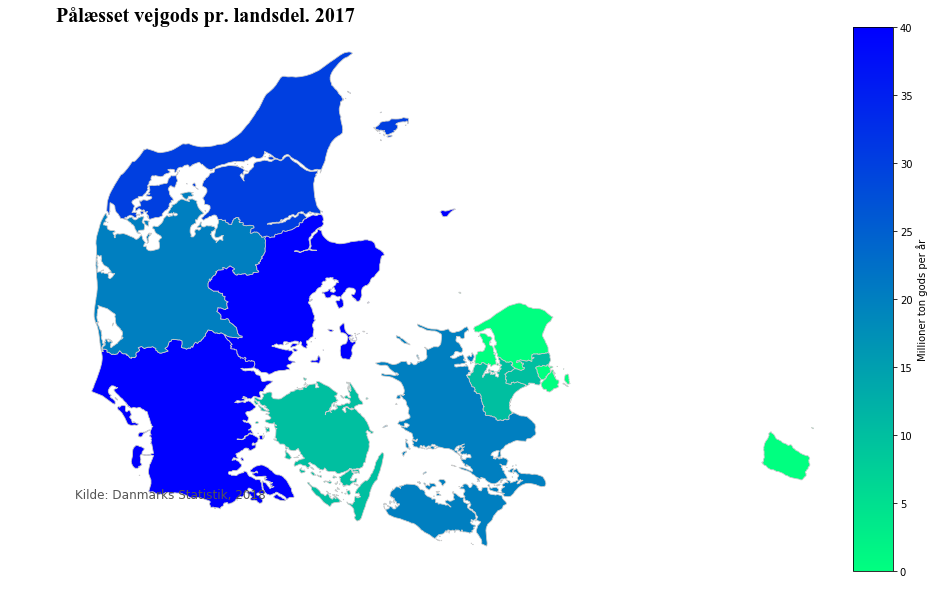

In [13]:
splits = 5 # antal kategorier kortet opdeles i
vmin, vmax = int(np.min(vg_paa_nuts3_dk['INDHOLD'])/5000)*5, int(1+np.max(vg_paa_nuts3_dk['INDHOLD'])/5000)*5
    
fig, ax = plt.subplots(figsize=(15,10))
ax.set_label('Label via method')
# add a title
ax.set_title('Pålæsset vejgods pr. landsdel. 2017', loc='left',
             fontdict={'family': 'Times New Roman', 'fontsize': '20', 'fontweight': 3})

img = vg_paa_nuts3_dk.plot(column='INDHOLD', scheme='equal_interval', cmap='winter_r', k=splits, linewidth=.8, edgecolor='.8', ax=ax)

ax.set_axis_off()

# Create colorbar as a legend
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

sm = plt.cm.ScalarMappable(cmap='winter_r', norm=plt.Normalize(vmin=vmin, vmax=vmax))
# empty array for the data range
sm._A = []
# add the colorbar to the figure
cbar = fig.colorbar(sm, cax=cax)
cbar.set_label('Millioner ton gods per år')

ax.annotate('Kilde: Danmarks Statistik, 2018',xy=(0.08, 0.18),  \
            xycoords='figure fraction', horizontalalignment='left', \
            verticalalignment='top', fontsize=12, color='#555555')
fig.savefig('pålæsset2017.png')

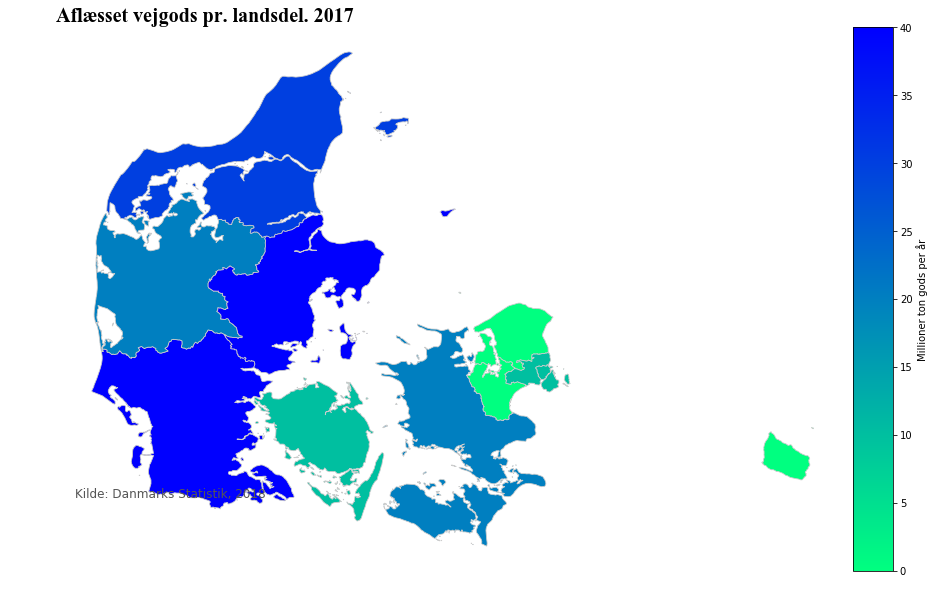

In [14]:
splits = 5 # antal kategorier kortet opdeles i
vmin, vmax = int(np.min(vg_af_nuts3_dk['INDHOLD'])/5000)*5, int(1+np.max(vg_af_nuts3_dk['INDHOLD'])/5000)*5

fig, ax = plt.subplots(figsize=(15,10))
ax.set_label('Label via method')
# add a title
ax.set_title('Aflæsset vejgods pr. landsdel. 2017', loc='left',
             fontdict={'family': 'Times New Roman', 'fontsize': '20', 'fontweight': 3})

img = vg_af_nuts3_dk.plot(column='INDHOLD', scheme='equal_interval', cmap='winter_r', 
                          k=splits, linewidth=.8, edgecolor='.8', ax=ax)

ax.set_axis_off()

# Create colorbar as a legend
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

sm = plt.cm.ScalarMappable(cmap='winter_r', norm=plt.Normalize(vmin=vmin, vmax=vmax))
# empty array for the data range
sm._A = []
# add the colorbar to the figure
cbar = fig.colorbar(sm, cax=cax)
cbar.set_label('Millioner ton gods per år')

ax.annotate('Kilde: Danmarks Statistik, 2018',xy=(0.08, 0.18),  \
            xycoords='figure fraction', horizontalalignment='left', \
            verticalalignment='top', fontsize=12, color='#555555')
fig.savefig('aflæsset2017.png')

C:\Users\pot\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


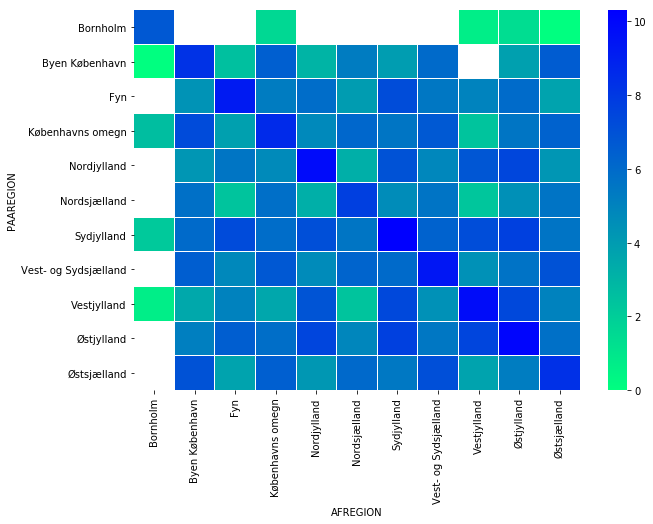

In [15]:
df['log_indhold'] = np.log(df['INDHOLD'])
vg = df[df['TID']=='2017'].pivot("PAAREGION", "AFREGION", "log_indhold")

f, ax = plt.subplots(figsize=(10,7))

ax.set_xlabel('Aflæsningslandsdel')
ax.set_ylabel('Pålæsningslandsdel')

img = sns.heatmap(vg, cmap='winter_r',  vmin=0, vmax=np.log(30000), linewidths=.01, ax=ax)

f.savefig('heatmap.png')